In [1]:
import ROOT
import os

os.environ["X509_USER_PROXY"] = "/eos/home-t/ttedesch/SWAN_projects/RDataFrame_porting/proxy" #path to your proxy file

ROOT.ROOT.EnableImplicitMT()

Welcome to JupyROOT 6.24/00


In [2]:
# Just-in-time compile custom helper function performing complex computations
ROOT.gInterpreter.Declare("""

using namespace ROOT::VecOps;
using RNode = ROOT::RDF::RNode;

using rvec_f = const RVec<float> &;
using rvec_i = const RVec<int> &;
using rvec_b = const RVec<bool> &;

const float PT_CUT_JET= 30;
const float DELTAETA_JJ_CUT=2.5;

RVec<size_t> GoodJets(rvec_i jetId, rvec_f eta, rvec_f pt, rvec_i puId){
   RVec<int> idx;
   for (size_t i = 0; i < pt.size(); i++) {
      if (jetId[i] >= 2 && abs(eta[i]) < 5. && pt[i] > PT_CUT_JET && (pt[i] > 50. || (pt[i] <= 50. && puId[i] >= 7))) idx.emplace_back(i);
   }
   return idx;
}

bool atleast2GoodJets(rvec_i GoodJets_idx){
    if (GoodJets_idx.size() >= 2) return true;
    else return false;
}

RVec<size_t> SelectVBSJets_invmass(rvec_f pt, rvec_f eta, rvec_f phi, rvec_f mass, rvec_i GoodJets_idx)
{
    RVec<size_t> idx;
    // Find first lepton pair with invariant mass closest to Z mass
    auto idx_cmb = Combinations(GoodJets_idx, 2);
    auto best_mass = -1;
    size_t best_i1 = 0; size_t best_i2 = 0;
    for (size_t i = 0; i < idx_cmb[0].size(); i++) {
        const auto i1 = idx_cmb[0][i];
        const auto i2 = idx_cmb[1][i];
        //std::cout<<i1<<i2<<endl;
        if (abs(eta[GoodJets_idx[i1]] - eta[GoodJets_idx[i2]]) >= DELTAETA_JJ_CUT) {
            ROOT::Math::PtEtaPhiMVector p1(pt[GoodJets_idx[i1]], eta[GoodJets_idx[i1]], phi[GoodJets_idx[i1]], mass[GoodJets_idx[i1]]);
            ROOT::Math::PtEtaPhiMVector p2(pt[GoodJets_idx[i2]], eta[GoodJets_idx[i2]], phi[GoodJets_idx[i2]], mass[GoodJets_idx[i2]]);
            const auto this_mass = (p1 + p2).M();
            if (this_mass > best_mass) {
                best_mass = this_mass;
                best_i1 = GoodJets_idx[i1];
                best_i2 = GoodJets_idx[i2];
            }
        }
    } 
    idx.emplace_back(best_i1);
    idx.emplace_back(best_i2);
    return idx;
}

float GetLeading(rvec_f x, rvec_i idx){
    return x[idx[0]];
}

""")

True

In [3]:
#read data
df = ROOT.RDataFrame("Events", "root://cms-xrd-global.cern.ch//store/mc/RunIIFall17NanoAODv7/VBS_SSWW_LL_polarization_TuneCP5_13TeV-madgraph-pythia8/NANOAODSIM/PU2017_12Apr2018_Nano02Apr2020_102X_mc2017_realistic_v8-v1/100000/AA101ED1-3427-E44D-9D6E-82569A5A589C.root")

In [4]:
#print dataframe column names
#documentation about columns here https://cms-nanoaod-integration.web.cern.ch/integration/master/mc94X_doc.html
print(df.GetColumnNames())

{ "run", "luminosityBlock", "event", "HTXS_Higgs_pt", "HTXS_Higgs_y", "HTXS_stage1_1_cat_pTjet25GeV", "HTXS_stage1_1_cat_pTjet30GeV", "HTXS_stage1_1_fine_cat_pTjet25GeV", "HTXS_stage1_1_fine_cat_pTjet30GeV", "HTXS_stage1_2_cat_pTjet25GeV", "HTXS_stage1_2_cat_pTjet30GeV", "HTXS_stage1_2_fine_cat_pTjet25GeV", "HTXS_stage1_2_fine_cat_pTjet30GeV", "HTXS_stage_0", "HTXS_stage_1_pTjet25", "HTXS_stage_1_pTjet30", "HTXS_njets25", "HTXS_njets30", "btagWeight_CSVV2", "btagWeight_DeepCSVB", "CaloMET_phi", "CaloMET_pt", "CaloMET_sumEt", "ChsMET_phi", "ChsMET_pt", "ChsMET_sumEt", "nCorrT1METJet", "CorrT1METJet_area", "CorrT1METJet_eta", "CorrT1METJet_muonSubtrFactor", "CorrT1METJet_phi", "CorrT1METJet_rawPt", "nElectron", "Electron_deltaEtaSC", "Electron_dr03EcalRecHitSumEt", "Electron_dr03HcalDepth1TowerSumEt", "Electron_dr03TkSumPt", "Electron_dr03TkSumPtHEEP", "Electron_dxy", "Electron_dxyErr", "Electron_dz", "Electron_dzErr", "Electron_eCorr", "Electron_eInvMinusPInv", "Electron_energyErr", "El

Warning in <TClass::Init>: no dictionary for class edm::Hash<1> is available
Warning in <TClass::Init>: no dictionary for class edm::ProcessHistory is available
Warning in <TClass::Init>: no dictionary for class edm::ProcessConfiguration is available
Warning in <TClass::Init>: no dictionary for class edm::ParameterSetBlob is available
Warning in <TClass::Init>: no dictionary for class pair<edm::Hash<1>,edm::ParameterSetBlob> is available


In [5]:
#filter
df_atleast2Jets = df.Filter("nJet>2", "At least two jets")

In [6]:
#define
df_GoodJets = df_atleast2Jets.Define("GoodJets_idx", "GoodJets(Jet_jetId, Jet_eta, Jet_pt, Jet_puId)")

In [7]:
#combine more filters and defines in order to complete the VBS jets selection
df_atleast2GoodJets = df_GoodJets.Filter("atleast2GoodJets(GoodJets_idx)", "At least two good jets")
df_VBSjets = df_atleast2GoodJets.Define("VBSJet_idx", "SelectVBSJets_invmass(Jet_pt, Jet_eta, Jet_phi, Jet_mass, GoodJets_idx)")
df_2VBSjets = df_VBSjets.Filter("VBSJet_idx[0] != VBSJet_idx[1]", "2 VBS jets")

#define the variable to plot
df_VBSleadingjets = df_2VBSjets.Define("Leadingjet_pt", "GetLeading(Jet_pt, VBSJet_idx)")

In [8]:
#create histo
Leadingjet_pt = ("Leadingjet_pt", "Leadingjet_pt", 50, 0, 800)
h_VBS = {}
h_VBS["Leadingjet_pt"] = df_VBSleadingjets.Histo1D(Leadingjet_pt,"Leadingjet_pt")

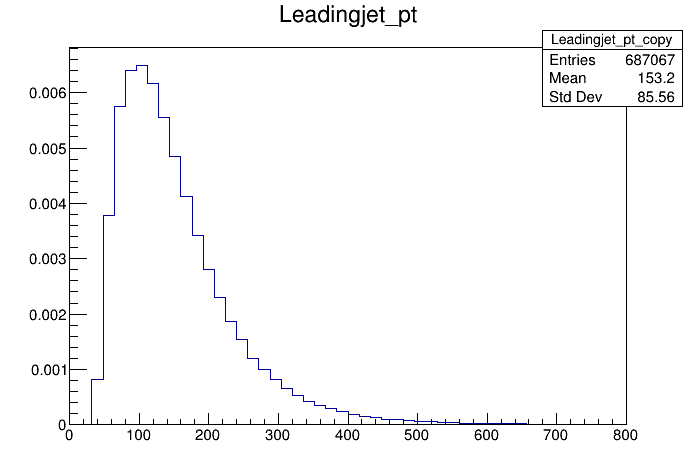

In [9]:
#simple plot
variables = ["Leadingjet_pt"]
canvases = []
legends = []

for i, v in enumerate(variables):
    canvases.append(ROOT.TCanvas())
    variable = variables[i]
    hist = h_VBS[variable]
    hist.Scale( 1./hist.Integral(),"WIDTH")
    hist = hist.DrawCopy('HIST') #this is an action that triggers the event loop
    canvases[i].Draw()

In [10]:
#see cut efficiencies
allCutsReport = df.Report() #another loop is triggered by this action (of course this is not the most efficient way to do this, actions and bookings are alternated just for example purposes)
allCutsReport.Print()

At least two jets: pass=902318     all=904500     -- eff=99.76 % cumulative eff=99.76 %
At least two good jets: pass=843116     all=902318     -- eff=93.44 % cumulative eff=93.21 %
2 VBS jets: pass=687556     all=843116     -- eff=81.55 % cumulative eff=76.02 %


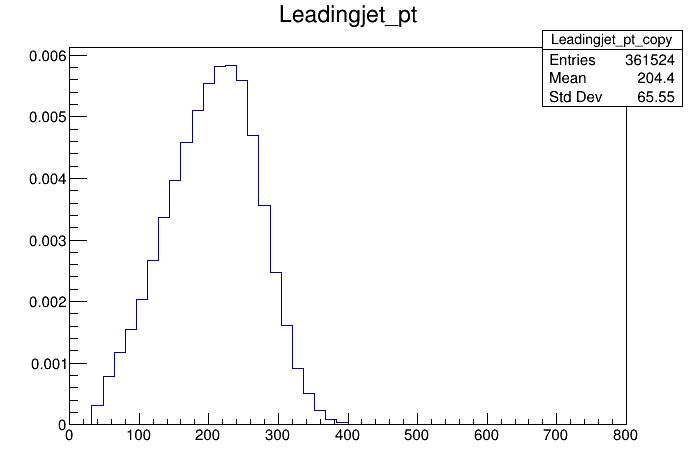

In [11]:
# do the same with another sample
df = ROOT.RDataFrame("Events", "root://cms-xrd-global.cern.ch//store/mc/RunIIFall17NanoAODv7/QCD_HT500to700_TuneCP5_13TeV-madgraph-pythia8/NANOAODSIM/PU2017_12Apr2018_Nano02Apr2020_102X_mc2017_realistic_v8-v1/60000/0A4D9D75-E598-1147-8E6A-574BAAD1B37F.root")
df_atleast2Jets = df.Filter("nJet>2", "At least two jets")
df_GoodJets = df_atleast2Jets.Define("GoodJets_idx", "GoodJets(Jet_jetId, Jet_eta, Jet_pt, Jet_puId)")
df_atleast2GoodJets = df_GoodJets.Filter("atleast2GoodJets(GoodJets_idx)", "At least two good jets")
df_VBSjets = df_atleast2GoodJets.Define("VBSJet_idx", "SelectVBSJets_invmass(Jet_pt, Jet_eta, Jet_phi, Jet_mass, GoodJets_idx)")
df_2VBSjets = df_VBSjets.Filter("VBSJet_idx[0] != VBSJet_idx[1]", "2 VBS jets")

df_VBSleadingjets = df_2VBSjets.Define("Leadingjet_pt", "GetLeading(Jet_pt, VBSJet_idx)")\

h_QCD = {}
h_QCD["Leadingjet_pt"] = df_VBSleadingjets.Histo1D(Leadingjet_pt,"Leadingjet_pt")

variables = ["Leadingjet_pt"]
canvases = []
legends = []

for i, v in enumerate(variables):
    canvases.append(ROOT.TCanvas())
    variable = variables[i]
    hist = h_QCD[variable]
    hist.Scale( 1./hist.Integral(),"WIDTH")
    hist = hist.DrawCopy('HIST')
    canvases[i].Draw()

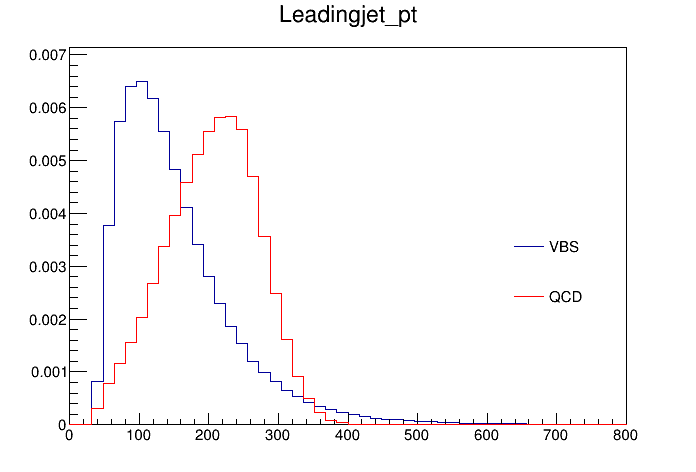

In [14]:
#plot them in the same canvas
variables = ["Leadingjet_pt"]

canvases = []
legends = []

for i, v in enumerate(variables):
    canvases.append(ROOT.TCanvas())
    variable = variables[i]
    h_qcd = h_QCD[variable]
    h_vbs = h_VBS[variable]
    h_qcd.Scale( 1./h_qcd.Integral(),"WIDTH")
    h_vbs.Scale( 1./h_vbs.Integral(),"WIDTH")
    maximum = max(h_qcd.GetMaximum(), h_vbs.GetMaximum())
    h_qcd.SetLineColor(2)
    h_qcd.GetYaxis().SetRangeUser(0,maximum+0.1*maximum)
    h_qcd.SetStats(False)
    h_vbs.SetStats(False)
    h_vbs.GetYaxis().SetRangeUser(0,maximum+0.1*maximum)
    h1 = h_vbs.DrawCopy('HIST')
    h2 = h_qcd.DrawCopy('HIST SAME')
    legends.append(ROOT.TLegend(.73,.32,.97,.53))
    legends[i].SetBorderSize(0)
    legends[i].SetFillColor(0)
    legends[i].SetFillStyle(0)
    legends[i].SetTextFont(42)
    legends[i].SetTextSize(0.035)
    legends[i].AddEntry(h1, "VBS", "L")
    legends[i].AddEntry(h2, "QCD", "L")
    legends[i].Draw()
    canvases[i].Draw()
    #c.Show()